In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import andrews_curves
from statsmodels.nonparametric.smoothers_lowess import lowess
red_wine=pd.read_csv("winequality-red.csv",sep=";")
white_wine=pd.read_csv("winequality-white.csv",sep=";")

In [2]:
#Fixed acidity refers to tartaric acid, the primary acid taste in wine, essential to mouthfeel and balance, adding an additional complexity to wine
#Citric acid is the fruity flavour. Adds some acidity, used less frequently due to the strong flavour and tendecy to break down to vinegar/ethanol.
#Volatile acidity is the gaseous acidic elements of a wine. Creates a vinegar/nail polish remover smell. Usualy undesirable

In [ ]:
#There's a couple of strong relations:
#(Free SO2-Total SO2) (Alcohol-Density)
#Some more moderate relations:
#(Total SO2-Residual sugar)  (Density-Residual sugar)

#In general, we see that quality increases as alcohol, citric acid, free SO2, residual sugar increase
#Quality increases as chlorides, density and volatile acidity decrease
#Fixed acidity, pH, sulphates and total SO2 do not have a noticeable effect

#However, significant correlation exists only for alcohol, volatile acidity and chlorides.
#Quantity increases as volatile acidity and chlorides decrease. Also when alcohol and free SO2 increase

#The aforementioned observations were made for the combined wine dataset, and are the variables that have significant effect on both types

In [3]:
#Column renaming according to usual conventions
red_wine.columns=red_wine.columns.str.replace(" ","_")
white_wine.columns=white_wine.columns.str.replace(" ","_")
red_wine["type"]="red"
white_wine["type"]="white"
red_wine.Name="Red wines"
white_wine.name="White wines"
#Categorization of quality into three groups
red_wine["quality_label"] = red_wine["quality"].apply(lambda value: "low" if value <= 5 else "medium" if value <= 7 else "high")
white_wine["quality_label"]=white_wine["quality"].apply(lambda value: "low" if value<=5 else "medium" if value<=7 else "high")
red_wine["quality_label"]=pd.Categorical(red_wine["quality_label"],categories=["low","medium","high"])
white_wine["quality_label"]=pd.Categorical(white_wine["quality_label"],categories=["low","medium","high"])

In [4]:
wines=pd.concat([red_wine,white_wine])
wines=wines.sample(frac=1,random_state=42).reset_index(drop=True)

In [ ]:
conr=red_wine.describe().applymap("{:.2f}".format)
conw=white_wine.describe().applymap("{:.2f}".format)
keys=["Red Whine Statistics","White Wine Statistics"]
wines_sum=pd.concat((conr,conw),axis=0, keys=keys)
del conr,conw,keys
wines_sum

<AxesSubplot:title={'center':'Distribution of wines based on colour'}, ylabel='type'>

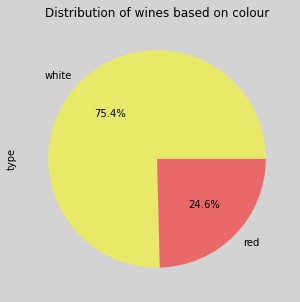

In [6]:
fig= plt.subplots(figsize=(5,5),facecolor="lightgrey")
wines["type"].value_counts().plot(kind="pie", autopct="%.1f%%", wedgeprops={"alpha":0.5}, colors=["yellow","red"], title="Distribution of wines based on colour")

Text(0.5, 0, 'Wine quality')

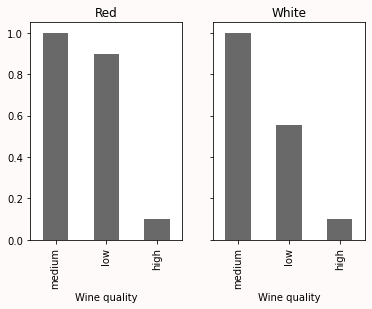

In [7]:
tempr=pd.DataFrame(data={"quality_label":["low","medium","high"],"count":red_wine.value_counts(subset="quality_label")})
tempw=pd.DataFrame(data={"quality_label":["low","medium","high"],"count":white_wine.value_counts(subset="quality_label")})
#Normalized for better understanding due to the radically different dataframe sizes
fig, axes = plt.subplots(1,2, sharey=True, squeeze=True, facecolor="snow")
tempr["count"]=preprocessing.minmax_scale(tempr["count"], feature_range=(0.1, 1))
tempw["count"]=preprocessing.minmax_scale(tempw["count"], feature_range=(0.1, 1))
tempr["count"].plot(kind='bar',ax=axes[0],color=["dimgray"]); axes[0].set_title('Red'); axes[0].set_xlabel("Wine quality")
tempw["count"].plot(kind='bar',ax=axes[1],color=["dimgray"]); axes[1].set_title('White'); axes[1].set_xlabel("Wine quality")

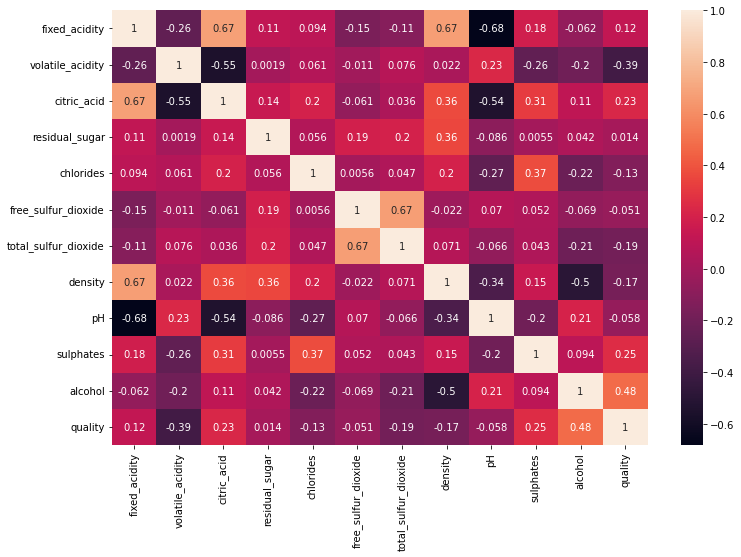

,quality
quality,1.000000
alcohol,0.476166
sulphates,0.251397
citric_acid,0.226373
fixed_acidity,0.124052
residual_sugar,0.013732
free_sulfur_dioxide,-0.050656
pH,-0.057731
chlorides,-0.128907
density,-0.174919


In [36]:
#Heatmap for red wines
plt.figure(figsize=(12,8))
sns.heatmap(red_wine.corr(),color="k",annot=True)
plt.show()
red_wine.corr()[["quality"]].sort_values(by="quality",ascending=False)

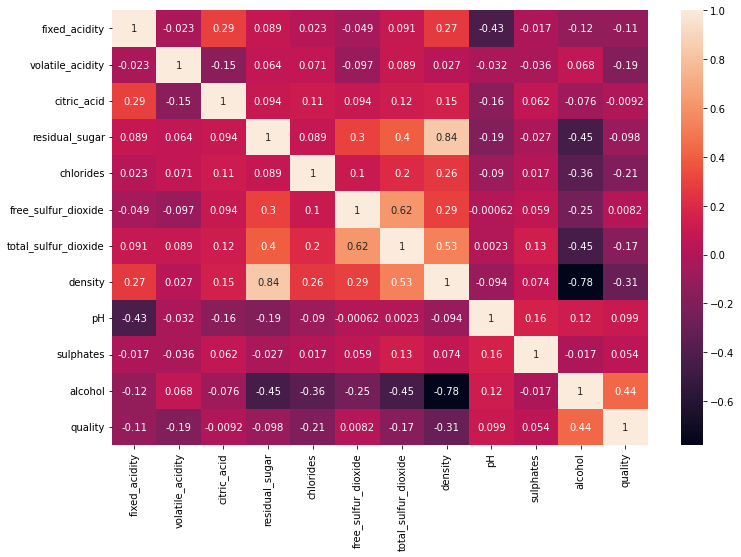

,quality
quality,1.000000
alcohol,0.435575
pH,0.099427
sulphates,0.053678
free_sulfur_dioxide,0.008158
citric_acid,-0.009209
residual_sugar,-0.097577
fixed_acidity,-0.113663
total_sulfur_dioxide,-0.174737
volatile_acidity,-0.194723


In [35]:
#Heatmap for white wines
plt.figure(figsize=(12,8))
sns.heatmap(white_wine.corr(),color="k",annot=True)
plt.show()
white_wine.corr()[["quality"]].sort_values(by="quality",ascending=False)

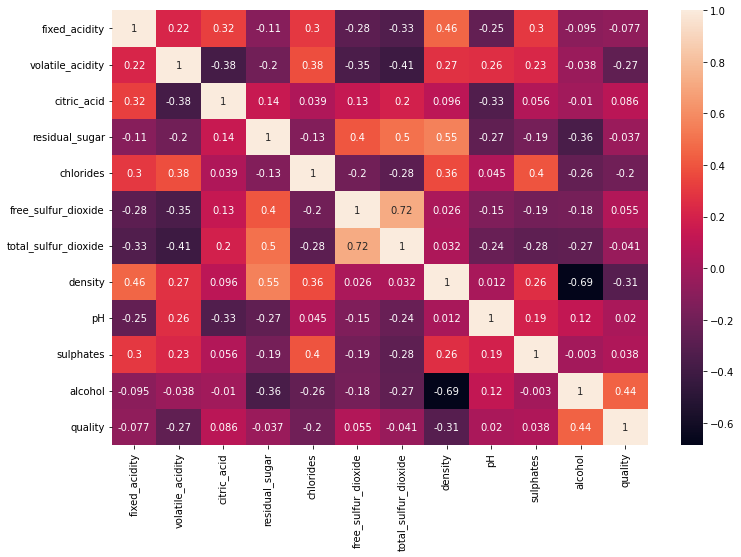

,quality
quality,1.000000
alcohol,0.444319
citric_acid,0.085532
free_sulfur_dioxide,0.055463
sulphates,0.038485
pH,0.019506
residual_sugar,-0.036980
total_sulfur_dioxide,-0.041385
fixed_acidity,-0.076743
chlorides,-0.200666


In [34]:
#Heatmap for all wines
plt.figure(figsize=(12,8))
sns.heatmap(wines.corr(),color="k",annot=True)
plt.show()
#Alcohol, volatile acidity, density and chlorides influence a wine's quality
wines.corr()[["quality"]].sort_values(by="quality",ascending=False)

In [37]:
#Creates a boxplot for variables xy to z of winetype dataset. If out==False removes outliers
def boxplotter(x,y,z,winetype,out):
    fig, axes = plt.subplots(1,2, figsize=(10,10),facecolor="snow")
    temp=winetype[[z,x]]
    temp.boxplot(by=z, ax=axes[0],showfliers=out,notch=True,patch_artist=True,color="dimgray");axes[0].set_title(""); axes[0].set_xlabel(z); axes[0].set_ylabel(x)
    temp=winetype[[z,y]]
    temp.boxplot(by=z, ax=axes[1],showfliers=out,notch=True,patch_artist=True,color="dimgray");axes[1].set_title(""); axes[1].set_xlabel(z); axes[1].set_ylabel(y)
    fig.suptitle(winetype.name)

#Normalizes a dataset
def normalizer(df): 
    df=df.drop(["type","quality_label"],axis=1)
    scaler=MinMaxScaler()
    scaler.fit(df)
    scaled=scaler.fit_transform(df)
    scaled_df=pd.DataFrame(scaled,columns=df.columns)
    return scaled_df

#Takes a,b variables for x and y axis respectively. cde are the dataframes and f a boolean vlaue for normalization
def plotter(a,b,c,d,nor):
    if nor:
        c=normalizer(c)
        d=normalizer(d)
    fig, axes = plt.subplots(1,2, figsize=(14,7),facecolor="snow")
    x=sns.regplot(ax=axes[0],x=c[a],y=c[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"})
    y=sns.regplot(ax=axes[1],x=d[a],y=d[b],lowess=True,scatter_kws={"color":"crimson"},line_kws={"color":"black"})
    return x,y

#Graphs relationship between x,y variables on df dataset
def rel_check(x,y,df):
    gg=sns.JointGrid(x=x,y=y,data=df)
    gg=gg.plot_joint(sns.regplot,color="crimson")
    gg=gg.plot_marginals(sns.histplot,kde=True,color="goldenrod")
    return gg

#Multigraphs kde,scatter and hist for all variables (It takes time)
def exp(df):
    pp = sns.PairGrid(wines)
    pp = pp.map_upper(sns.kdeplot,cmap="hot",shade=True,thresh=False)
    pp = pp.map_diag(plt.hist,color="darkgrey")
    pp = pp.map_lower(sns.scatterplot,color="crimson",edgecolor="k")
    return pp

#Used for the removal of outliers
def correction(val,first,ninenine):
    if (val>=first)&(val<=ninenine):
        return val
    else:
        return np.NaN

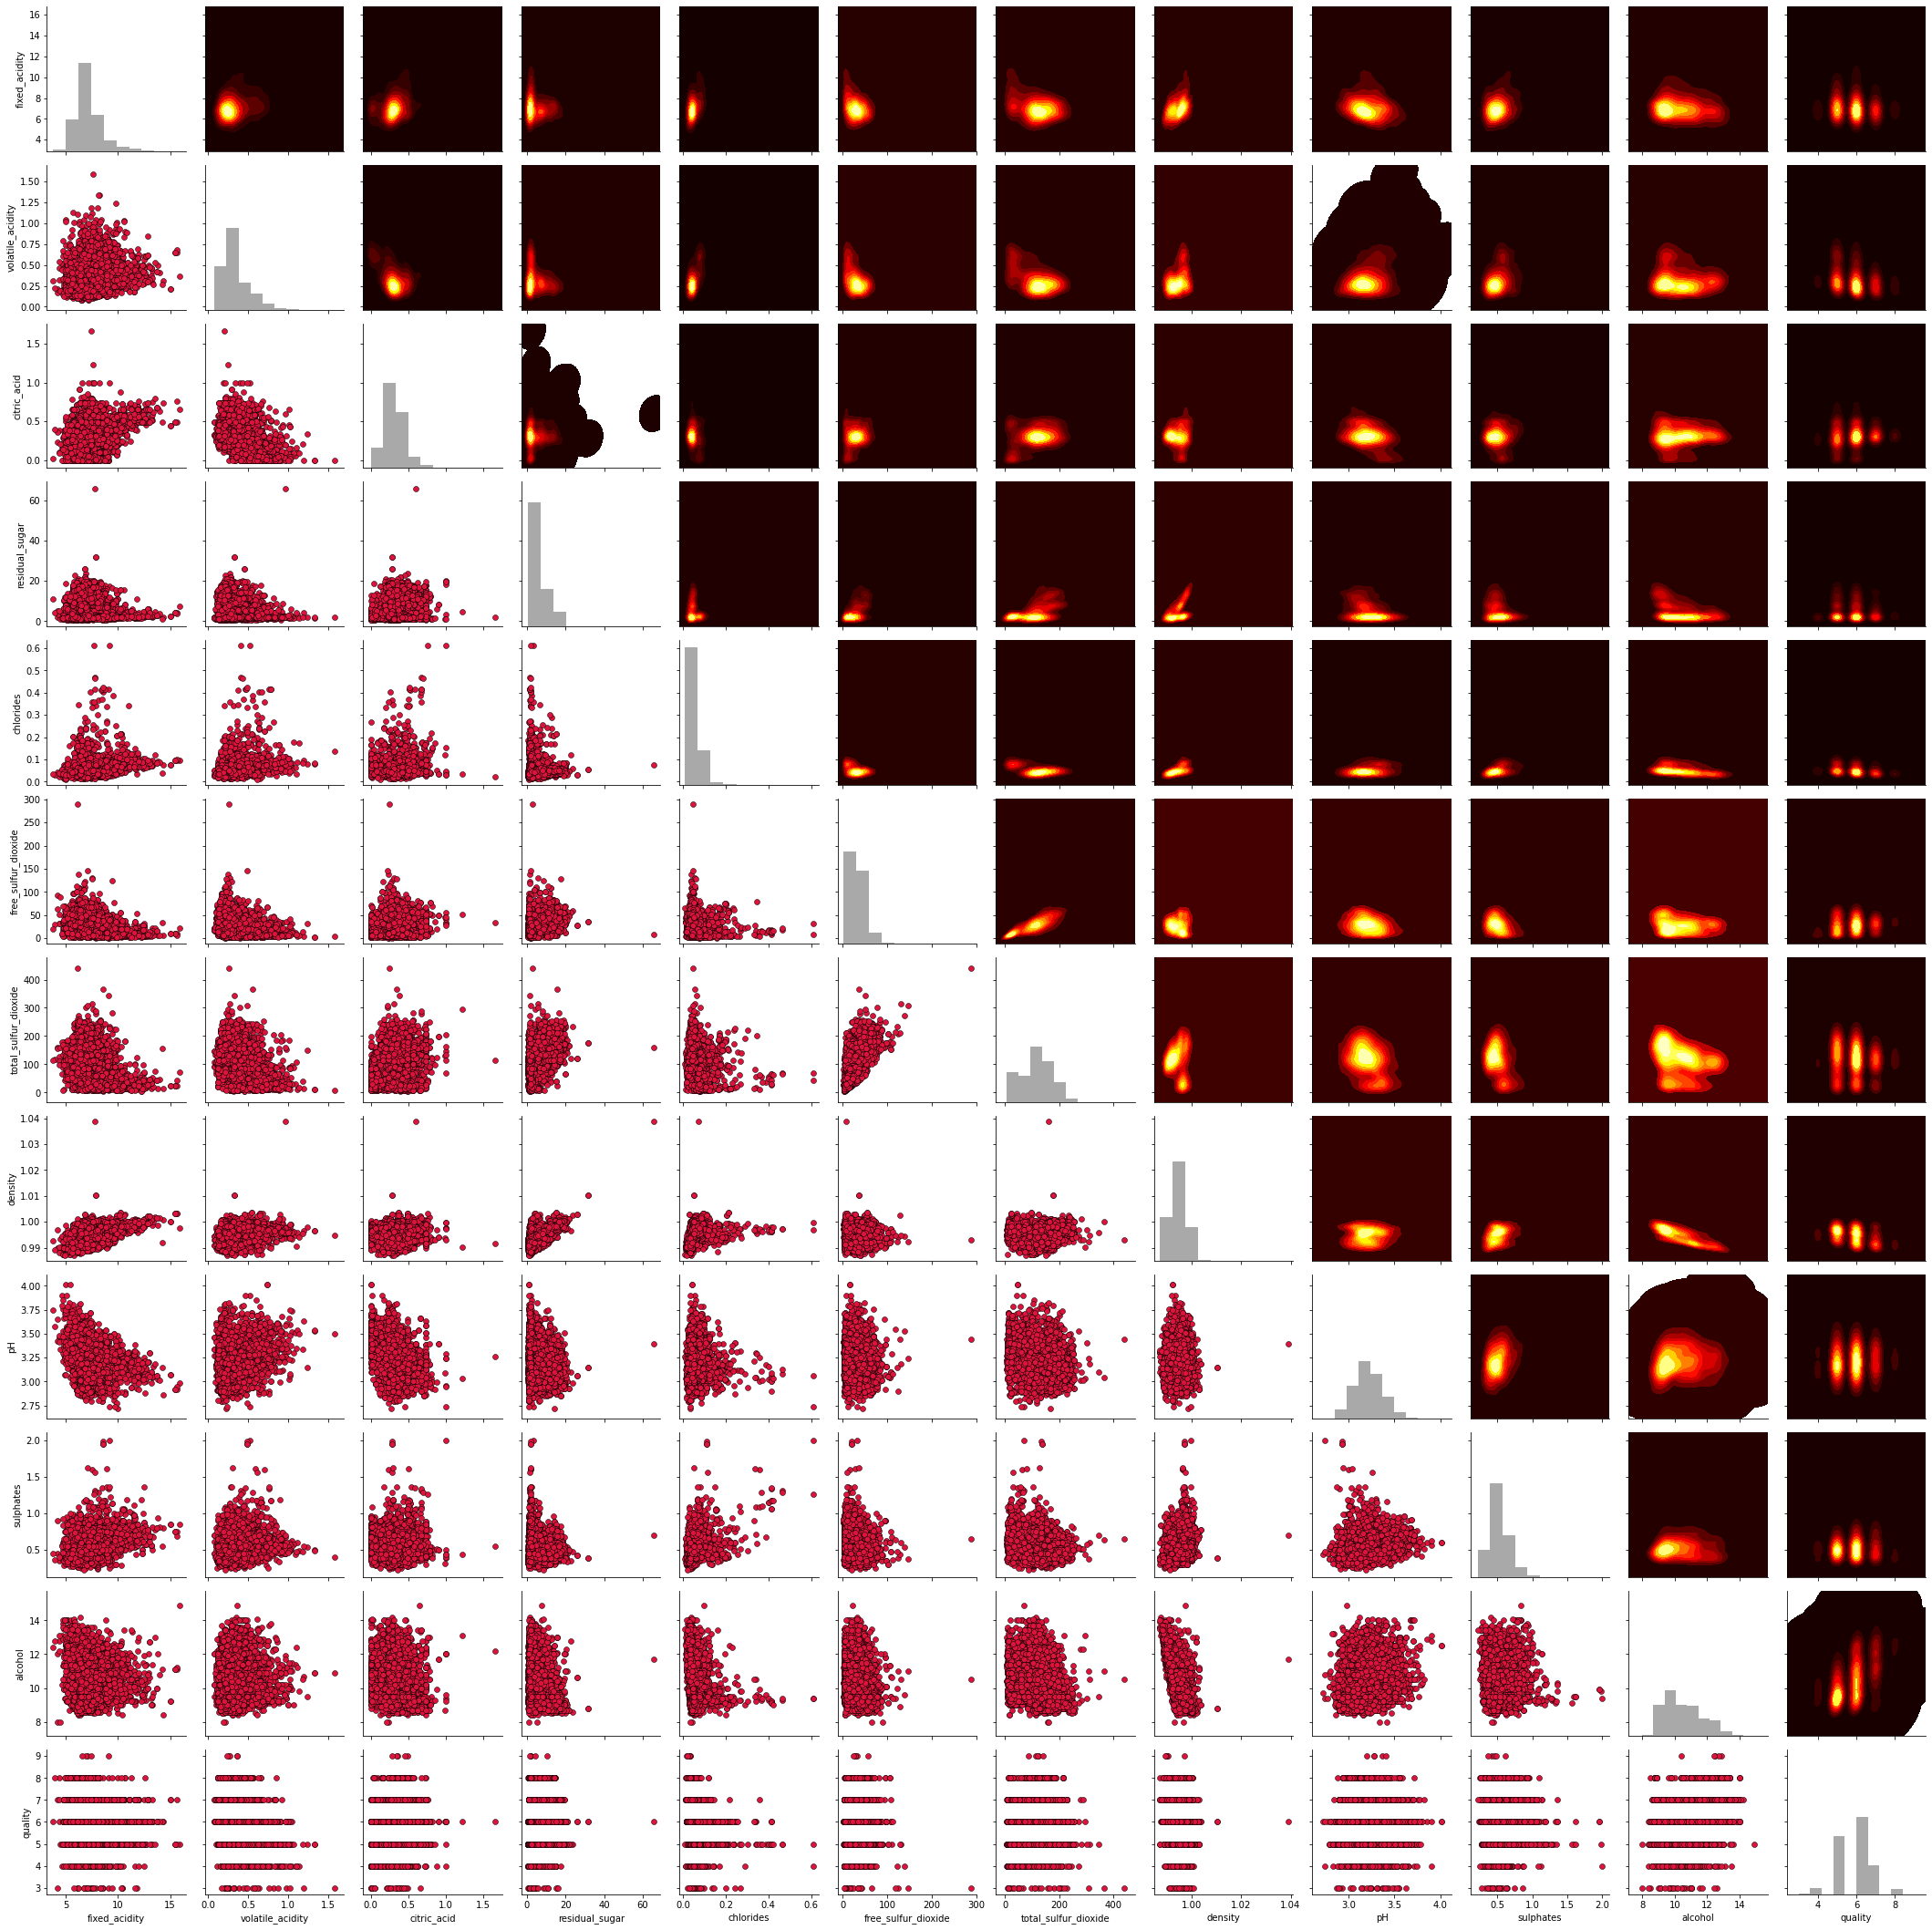

In [12]:
exp(wines)

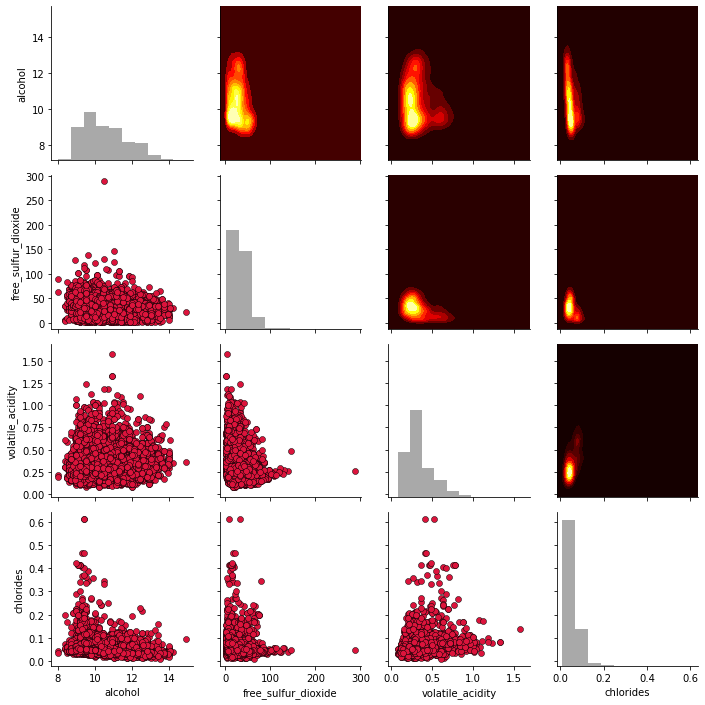

In [30]:
exp(wines[["alcohol","free_sulfur_dioxide","volatile_acidity","chlorides"]])

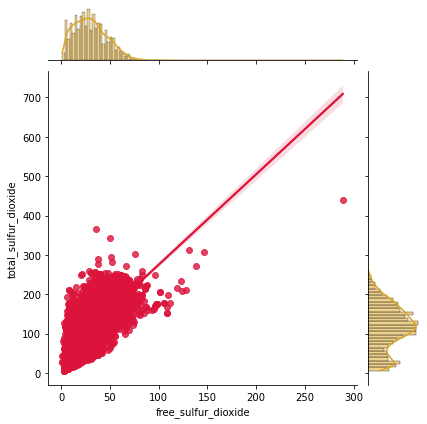

In [29]:
rel_check("free_sulfur_dioxide","total_sulfur_dioxide",wines)

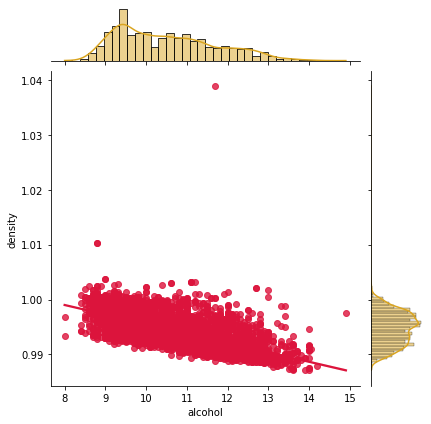

In [16]:
rel_check("alcohol","density",wines)

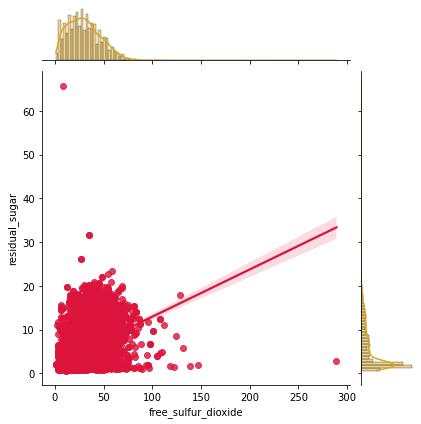

In [31]:
rel_check("free_sulfur_dioxide","residual_sugar",wines)

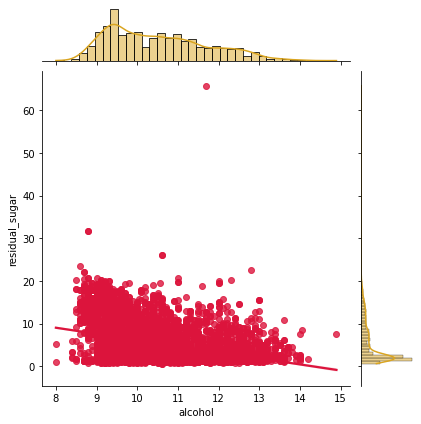

In [32]:
rel_check("alcohol","residual_sugar",wines)

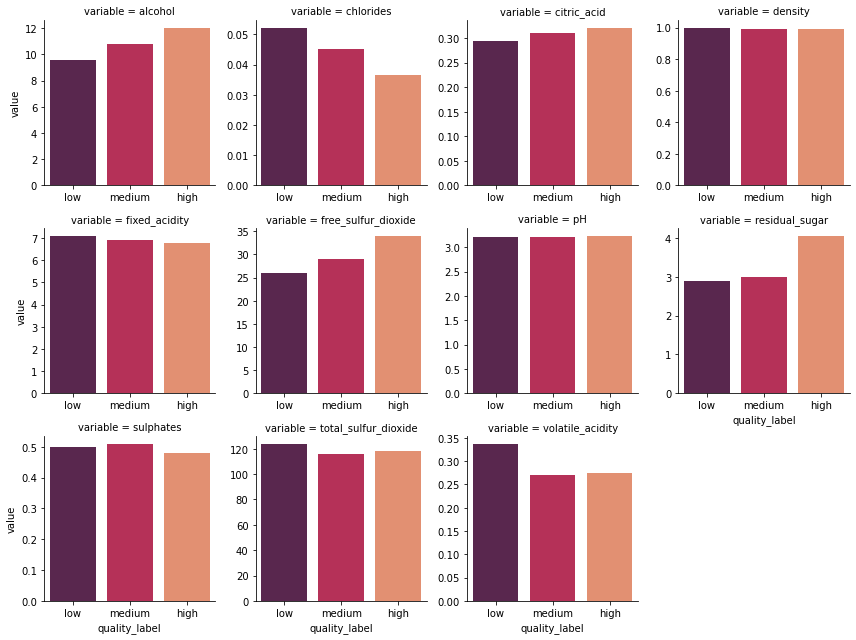

In [53]:
#Create a new dataframe g1, with quality and qualit label columns serving as identifiers
g1=pd.melt(wines,id_vars=["quality","quality_label"],value_vars=wines.columns[:12],var_name="variable",value_name="value")
g1.sort_values(by=["variable","quality"],ascending=[True,True],inplace=True)
g1.reset_index(drop=True,inplace=True)
g1.quality=g1.quality.astype("str")
g1.quality=g1.quality.astype("category")
#Create histplots for every variable binned by quality label
g1=g1.groupby(by=["variable","quality_label"],as_index=False)[["value"]].median()
pp=sns.FacetGrid(g1,col="variable",col_wrap=4,sharey=False,sharex=False,height=3,aspect=1,
hue="quality_label",hue_order=["low","medium","high"],palette="rocket")
pp.map(sns.barplot,"quality_label","value",order=["low","medium","high"])
plt.show()

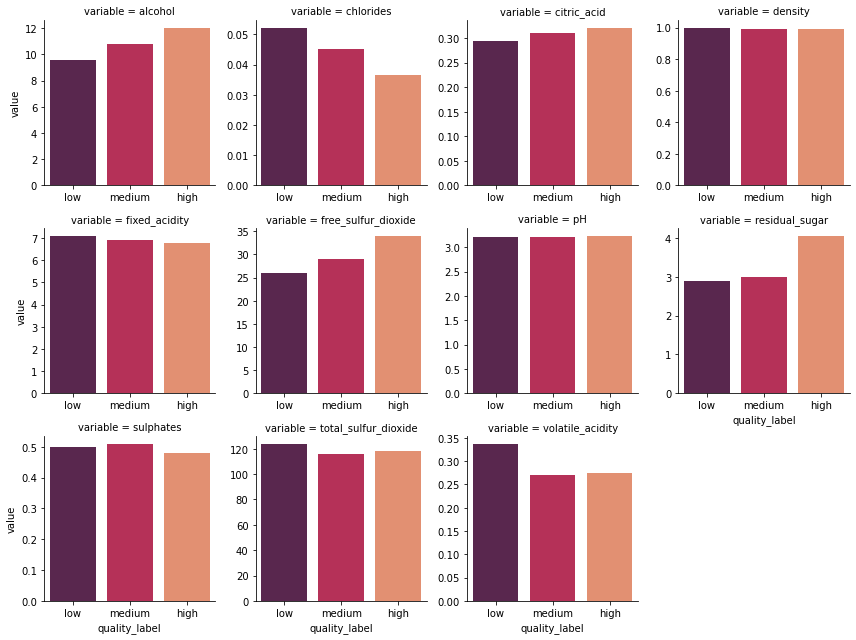

In [52]:
#Let's do the same after removing the top and bottom 1%
g2=pd.melt(wines,id_vars=["quality","quality_label"],value_vars=wines.columns[:12],var_name="variable",value_name="value")
g2.sort_values(by=["variable","quality"],ascending=[True,True],inplace=True)
g2.reset_index(drop=True,inplace=True)
g2.quality=g2.quality.astype("str")
g2.quality=g2.quality.astype("category")
#Start of removal process
q1=g2.groupby(["quality","variable"],as_index=False)[["value"]].quantile(0.1)
q1.rename(columns={"value":"1%"},inplace=True)
q99=g2.groupby(["quality","variable"],as_index=False)[["value"]].quantile(.99)
q99.rename(columns={"value":"99%"},inplace=True)
g2=g2.merge(q1,on=["quality","variable"]).merge(q99,on=["quality","variable"])
g2["correction"]=g2.apply(lambda x: correction(x["value"],x["1%"],x["99%"]),axis=1)
g2=g2[["quality","quality_label","variable","value"]]
#End of process
g2=g2.groupby(by=["variable","quality_label"],as_index=False)[["value"]].median()
pp=sns.FacetGrid(g2,col="variable",col_wrap=4,sharey=False,sharex=False,height=3,aspect=1,
hue="quality_label",hue_order=["low","medium","high"],palette="rocket")
pp.map(sns.barplot,"quality_label","value",order=["low","medium","high"])
plt.show()

In [ ]:
#Having done all that we can check the correlation for each pair of significant value to quality

In [ ]:
plotter("free_sulfur_dioxide","quality",red_wine,white_wine,False)

In [ ]:
plotter("chlorides","quality",red_wine,white_wine,False)

In [ ]:
plotter("volatile_acidity","quality",red_wine,white_wine,False)

In [ ]:
plotter("alcohol","quality",red_wine,white_wine,False)